# XGBOOST

In [104]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [105]:

# Load dataset
data_xgboost = pd.read_csv('data_xgboost.csv')
data_xgboost = pd.DataFrame(data_xgboost)


# Convert 'CRASH_DATE' to datetime format and set it as the index
data_xgboost['CRASH_DATE'] = pd.to_datetime(data_xgboost['CRASH_DATE'])
# Aggregate data to get daily crash counts
data_xgboost.set_index('CRASH_DATE', inplace=True)
data_xgboost = data_xgboost.resample('H').size().to_frame(name='COUNT')

# Extract time-based features
data_xgboost['dayoftheweek'] = data_xgboost.index.dayofweek
data_xgboost['hour'] = data_xgboost.index.hour
data_xgboost['month'] = data_xgboost.index.month
data_xgboost['year'] = data_xgboost.index.year
data_xgboost['dayofthemonth'] = data_xgboost.index.day
data_xgboost['dayoftheyear'] = data_xgboost.index.dayofyear

# Fix for weekoftheyear to work on all pandas versions
data_xgboost['weekoftheyear'] = data_xgboost.index.to_series().dt.isocalendar().week


# Display the modified DataFrame
data_xgboost



C:\Users\byash\AppData\Local\Temp\ipykernel_46268\2307861490.py:10: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  data_xgboost = data_xgboost.resample('H').size().to_frame(name='COUNT')


,COUNT,dayoftheweek,hour,month,year,dayofthemonth,dayoftheyear,weekoftheyear
CRASH_DATE,,,,,,,,
2016-01-01 00:00:00,5,4,0,1,2016,1,1,53
2016-01-01 01:00:00,8,4,1,1,2016,1,1,53
2016-01-01 02:00:00,9,4,2,1,2016,1,1,53
2016-01-01 03:00:00,5,4,3,1,2016,1,1,53
2016-01-01 04:00:00,4,4,4,1,2016,1,1,53
...,...,...,...,...,...,...,...,...
2024-12-31 19:00:00,14,1,19,12,2024,31,366,1
2024-12-31 20:00:00,16,1,20,12,2024,31,366,1
2024-12-31 21:00:00,7,1,21,12,2024,31,366,1


In [106]:

data_xgboost['lag1'] = data_xgboost['COUNT'].shift(1)  # Previous hour
data_xgboost['lag3'] = data_xgboost['COUNT'].shift(3)  # 3 hours ago
data_xgboost['lag6'] = data_xgboost['COUNT'].shift(6)  # 6 hours ago
data_xgboost['lag12'] = data_xgboost['COUNT'].shift(12)  # Half-day (12 hours)
data_xgboost['lag24'] = data_xgboost['COUNT'].shift(24)  # 1-day lag

In [107]:

data_xgboost['rolling_mean_6'] = data_xgboost['COUNT'].rolling(window=6).mean()
data_xgboost['rolling_mean_12'] = data_xgboost['COUNT'].rolling(window=12).mean()
data_xgboost['rolling_mean_24'] = data_xgboost['COUNT'].rolling(window=24).mean()
data_xgboost['expanding_mean'] = data_xgboost['COUNT'].expanding().mean()


In [108]:
lags = data_xgboost[['COUNT', 'lag1', 'lag3', 'rolling_mean_6','rolling_mean_12']].head(12)
styled_metrics = lags.style.set_table_styles([
    {'selector': 'thead th', 'props': [('background-color', 'white'), ('color', 'black'), ('border', '2px solid black')]},  # Column Headers
    {'selector': 'tbody td', 'props': [('background-color', 'white'), ('color', 'black'), ('border', '1px solid black')]},  # Table Body with Borders
    {'selector': 'tbody tr th', 'props': [('background-color', 'white'), ('color', 'black'), ('border', '2px solid black')]},  # Index Column with Borders
    {'selector': 'table', 'props': [('border-collapse', 'collapse'), ('border', '2px solid black')]}  # Ensures borders don't overlap
])

# Display Styled Table
display(styled_metrics)

,COUNT,lag1,lag3,rolling_mean_6,rolling_mean_12
CRASH_DATE,,,,,
2016-01-01 00:00:00,5,nan,nan,nan,nan
2016-01-01 01:00:00,8,5.000000,nan,nan,nan
2016-01-01 02:00:00,9,8.000000,nan,nan,nan
2016-01-01 03:00:00,5,9.000000,5.000000,nan,nan
2016-01-01 04:00:00,4,5.000000,8.000000,nan,nan
2016-01-01 05:00:00,1,4.000000,9.000000,5.333333,nan
2016-01-01 06:00:00,1,1.000000,5.000000,4.666667,nan
2016-01-01 07:00:00,0,1.000000,4.000000,3.333333,nan
2016-01-01 08:00:00,1,0.000000,1.000000,2.000000,nan


Mean Squared Error: 12.913066864013672
R² Score: 0.8672227263450623


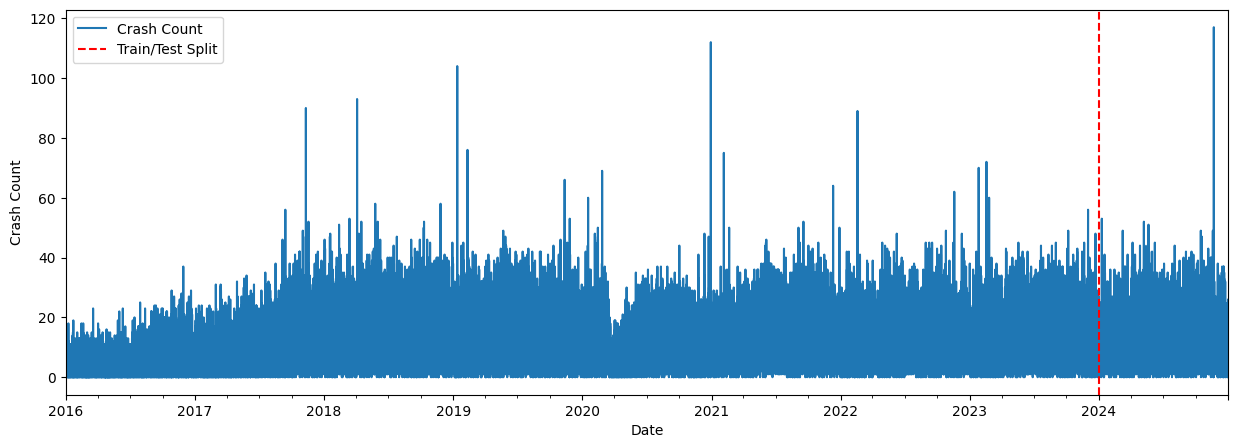

In [112]:
from xgboost import XGBRegressor

# Splitting the dataset
train = data_xgboost.iloc[data_xgboost.index< "2024-01-01"]
test = data_xgboost.iloc[data_xgboost.index >= "2024-01-01"]

FEATURES = [
    'dayoftheyear', 'hour', 'dayoftheweek', 'month', 'year', 
    'dayofthemonth', 'weekoftheyear',  # Existing features
    'lag1', 'lag3', 'lag6', 'lag12', 'lag24',  # Short-term dependencies
    'rolling_mean_6', 'rolling_mean_12', 'rolling_mean_24',  # Smoothed trends
    'expanding_mean'  # Long-term trend
]
TARGET = 'COUNT'

# Define Model
reg = XGBRegressor(
    base_score=0.5,
    booster='gbtree',
    n_estimators=700,  # 🔹 Reduce to prevent overfitting
    learning_rate=0.03,  # 🔹 Lower learning rate for better generalization
    max_depth=6,  # 🔹 Slightly deeper trees (more data supports this)
    subsample=0.8,  # 🔹 Use only 80% of data per tree (prevents overfitting)
    colsample_bytree=0.8,  # 🔹 Use 80% of features per tree (reduces redundancy)
    reg_lambda=10,  # 🔹 Stronger L2 regularization (prevents overfitting)
    reg_alpha=5,  # 🔹 L1 regularization (helps feature selection)
    early_stopping_rounds=20,  # 🔹 Stops training earlier if no improvement
    objective='reg:squarederror'
)

# Train Model (with early stopping)
reg.fit(
    train[FEATURES], train[TARGET],  # ✅ Training Data
    eval_set=[(train[FEATURES], train[TARGET]), (test[FEATURES], test[TARGET])],  # ✅ Validation Set
    verbose= False  # ✅ Show training progress
)

rr2_lag = reg.score(train[FEATURES], train[TARGET])
mse_lag = mean_squared_error(test[TARGET], reg.predict(test[FEATURES]))
print(f"Mean Squared Error: {mse_lag}")
print(f"R² Score: {rr2_lag}")

ax = data_xgboost[['COUNT']].plot(figsize=(15, 5))
plt.axvline(x=pd.Timestamp("2024-01-01"), linestyle='--', color='red')
plt.xlabel('Date')
plt.ylabel('Crash Count')
plt.legend(['Crash Count', 'Train/Test Split'])


In [113]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

tscv = TimeSeriesSplit(n_splits=5)

for train_idx, test_idx in tscv.split(data_xgboost):
    train_fold, test_fold = data_xgboost.iloc[train_idx], data_xgboost.iloc[test_idx]
    
    reg = XGBRegressor(
    base_score=0.5,
    booster='gbtree',
    n_estimators=700,  # 🔹 Reduce to prevent overfitting
    learning_rate=0.03,  # 🔹 Lower learning rate for better generalization
    max_depth=6,  # 🔹 Slightly deeper trees (more data supports this)
    subsample=0.8,  # 🔹 Use only 80% of data per tree (prevents overfitting)
    colsample_bytree=0.8,  # 🔹 Use 80% of features per tree (reduces redundancy)
    reg_lambda=10,  # 🔹 Stronger L2 regularization (prevents overfitting)
    reg_alpha=5,  # 🔹 L1 regularization (helps feature selection)
    early_stopping_rounds=20,  # 🔹 Stops training earlier if no improvement
    objective= 'reg:squarederror'
    )

    # ✅ Pass `eval_set` for early stopping
    reg.fit(
        train_fold[FEATURES], train_fold[TARGET],
        eval_set=[(test_fold[FEATURES], test_fold[TARGET])],  # ✅ Validation set required
        verbose =False  # ✅ Disable verbose output
    )

    print(f"Test R²: {reg.score(test_fold[FEATURES], test_fold[TARGET])}")
    r2_score_lag = reg.score(test_fold[FEATURES], test_fold[TARGET])
    print(f"Test RMSE: {mean_squared_error(test_fold[TARGET].dropna(), reg.predict(test_fold[FEATURES].dropna()))}")
    
from IPython.core.interactiveshell import InteractiveShell

# Set max lines displayed
InteractiveShell.ast_node_interactivity = "last_expr"




Test R²: 0.6296447515487671
Test RMSE: 28.94156265258789
Test R²: 0.8108575344085693
Test RMSE: 14.146904945373535
Test R²: 0.7947925329208374
Test RMSE: 12.859400749206543
Test R²: 0.8074320554733276
Test RMSE: 12.67797565460205
Test R²: 0.8249329328536987
Test RMSE: 12.62949275970459


In [114]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(data_xgboost['COUNT'])
print("ADF Statistic:", result[0])
print("p-value:", result[1])
if result[1] > 0.05:
    print("Time series is not stationary.")
else:
    print("Time series is stationary.")


ADF Statistic: -13.307769830561146
p-value: 6.842780454584551e-25
Time series is stationary.


R² Score: 0.8220229148864746


C:\Users\byash\AppData\Local\Temp\ipykernel_46268\1981575905.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['prediction'] = reg.predict(test[FEATURES])


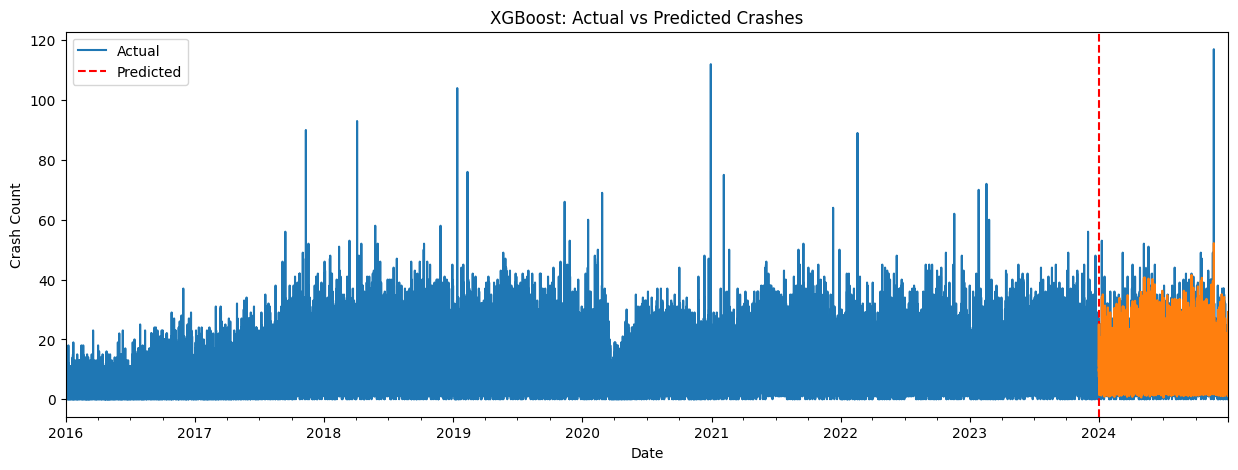

In [115]:
from sklearn.metrics import r2_score


# Drop existing 'prediction' columns to avoid merge conflict
test['prediction'] = reg.predict(test[FEATURES])
data_xgboost = data_xgboost.drop(columns=['prediction_x', 'prediction_y', 'prediction'], errors='ignore')

# Merge without conflicts
data_xgboost = data_xgboost.merge(test[['prediction']], how='left', left_index=True, right_index=True)
rr2 = r2_score(test[TARGET], test['prediction'])
print(f"R² Score: {rr2}")

# Plot results
ax = data_xgboost[['COUNT']].plot(figsize=(15, 5))
plt.axvline(x=pd.Timestamp("2024-01-01"), linestyle='--', color='red')
data_xgboost['prediction'].plot(ax=ax, style='-')

plt.title('XGBoost: Actual vs Predicted Crashes')
plt.xlabel('Date')
plt.ylabel('Crash Count')
plt.legend(['Actual', 'Predicted'])
plt.show()


In [116]:
rmse_lag = np.sqrt(mean_squared_error(test[TARGET], test['prediction']))
print(f"RMSE: {rmse_lag}")

RMSE: 3.5962519685264507


C:\Users\byash\AppData\Local\Temp\ipykernel_46268\1237945061.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['trend'] = decompose.trend
C:\Users\byash\AppData\Local\Temp\ipykernel_46268\1237945061.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['seasonal'] = decompose.seasonal
C:\Users\byash\AppData\Local\Temp\ipykernel_46268\1237945061.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See 

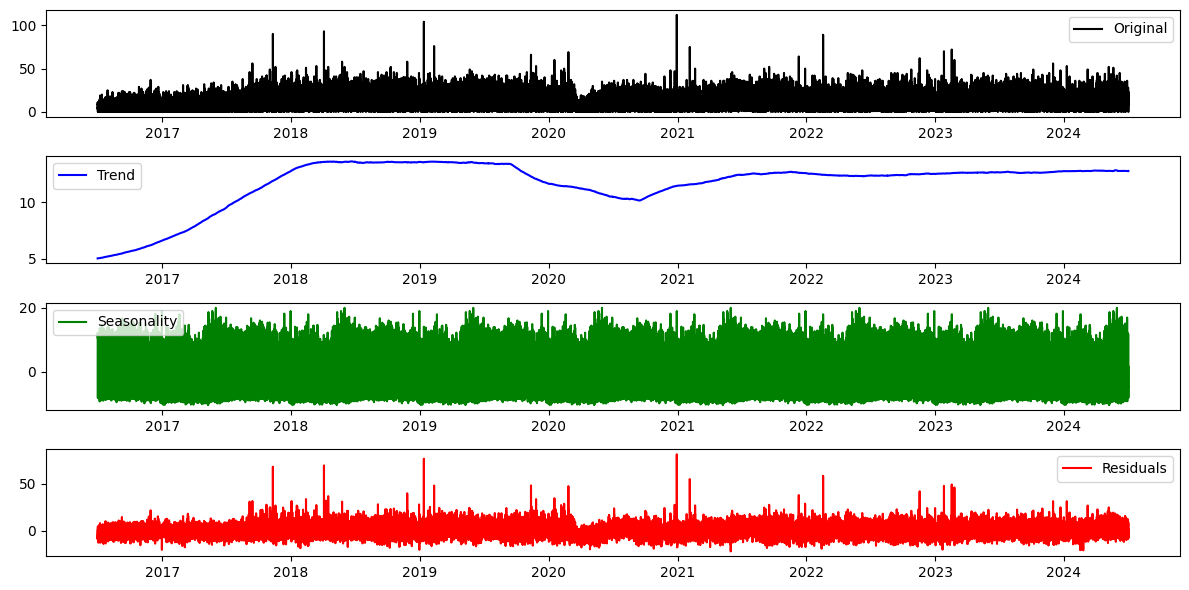

In [117]:
from statsmodels.tsa.seasonal import seasonal_decompose
df = data_xgboost[['COUNT']]
decompose = seasonal_decompose(df['COUNT'], model='additive', period=8760)
df['trend'] = decompose.trend
df['seasonal'] = decompose.seasonal
df['residual'] = decompose.resid

df = df.dropna()


plt.figure(figsize=(12, 6))
plt.subplot(411)
plt.plot(df["COUNT"], label="Original", color="black")
plt.legend()
plt.subplot(412)
plt.plot(df['trend'], label="Trend", color="blue")
plt.legend()
plt.subplot(413)
plt.plot(df['seasonal'], label="Seasonality", color="green")
plt.legend()
plt.subplot(414)
plt.plot(df['residual'], label="Residuals", color="red")
plt.legend()
plt.tight_layout()
plt.show()


    

In [118]:
df['dayoftheweek'] = df.index.dayofweek
df['hour'] = df.index.hour
df['month'] = df.index.month
df['year'] = df.index.year
df['dayofthemonth'] = df.index.day
df['dayoftheyear'] = df.index.dayofyear
df['weekoftheyear'] = df.index.to_series().dt.isocalendar().week


In [120]:
from sklearn.model_selection import TimeSeriesSplit

FEATURES = ['dayoftheyear', 'hour', 'dayoftheweek', 'month', 'year', 
        'dayofthemonth', 'weekoftheyear']

TARGET = 'residual'

tscv = TimeSeriesSplit(n_splits=6)

for train_idx, test_idx in tscv.split(df):
        train_fold, test_fold = df.iloc[train_idx], df.iloc[test_idx]
        
        reg = XGBRegressor(
        base_score=0.5,
        booster='gbtree',
        n_estimators=300,  # 🔹 Reduce to prevent overfitting
        learning_rate=0.03,  # 🔹 Lower learning rate for better generalization
        max_depth=6,  # 🔹 Slightly deeper trees (more data supports this)
        subsample=0.8,  # 🔹 Use only 80% of data per tree (prevents overfitting)
        colsample_bytree=0.8,  # 🔹 Use 80% of features per tree (reduces redundancy)
        reg_lambda=10,  # 🔹 Stronger L2 regularization (prevents overfitting)
        reg_alpha=5,  # 🔹 L1 regularization (helps feature selection)
        early_stopping_rounds=20,  # 🔹 Stops training earlier if no improvement
        objective='reg:squarederror'
        )

        # ✅ Pass `eval_set` for early stopping
        reg.fit(
            train_fold[FEATURES], train_fold[TARGET],
            eval_set=[(test_fold[FEATURES], test_fold[TARGET])],  # ✅ Validation set required
            verbose =False  # ✅ Disable verbose output
        )

        print(f"Test R²: {reg.score(test_fold[FEATURES], test_fold[TARGET])}")
        
df.loc[test_fold.index, "residual_forecast"] = reg.predict(test_fold[FEATURES])

Test R²: 0.011505894888134804
Test R²: 0.27090194073884255
Test R²: 0.03793186838827256
Test R²: 0.1514553953129263
Test R²: 0.2520115947458661
Test R²: 0.2885865979430019


In [121]:
df["final_forecast"] = df["residual_forecast"] + df["trend"] + df["seasonal"]


<Figure size 1200x500 with 0 Axes>

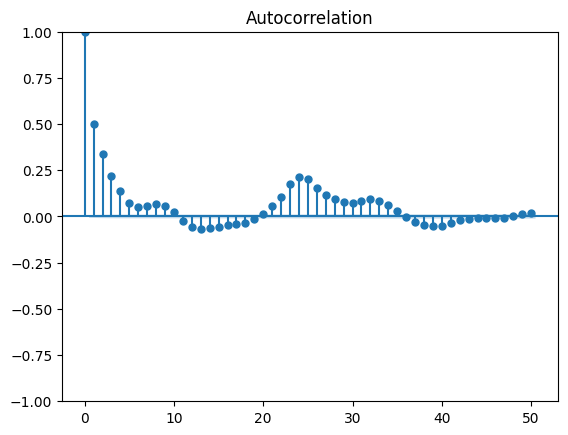

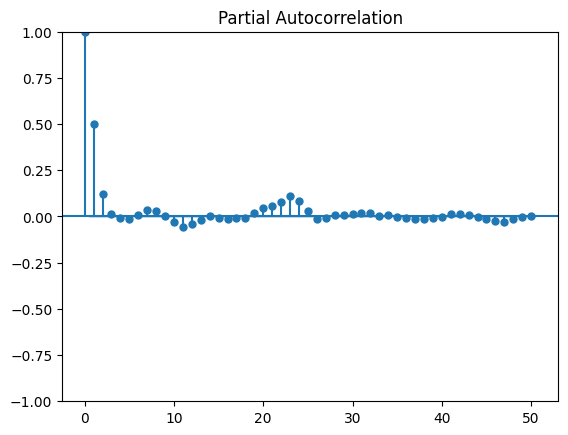

In [122]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plot_acf(df["residual"].dropna(), lags=50)  # Autocorrelation plot
plot_pacf(df["residual"].dropna(), lags=50)  # Partial autocorrelation plot
plt.show()


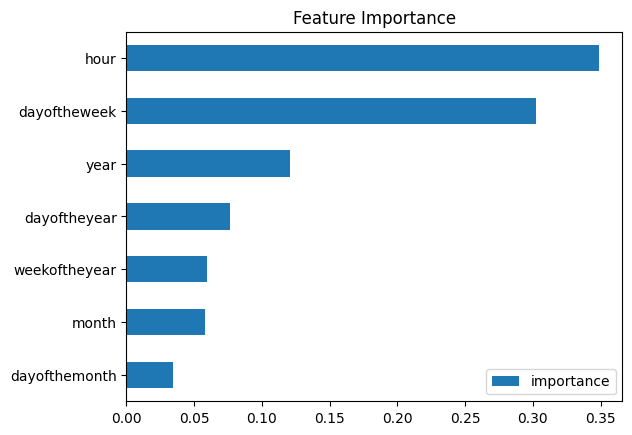

In [123]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

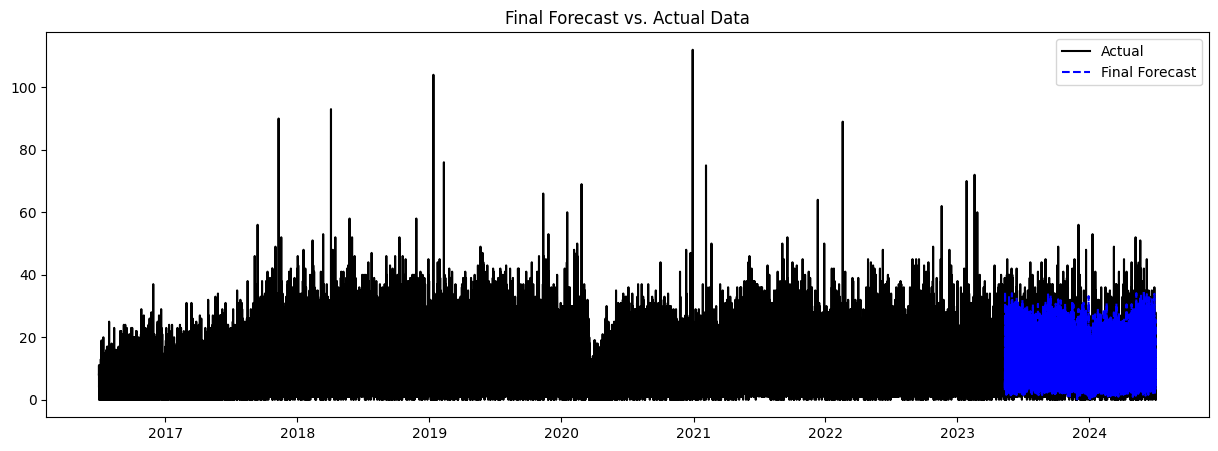

In [124]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))
plt.plot(df.index, df["COUNT"], label="Actual", color="black")
plt.plot(df.index, df["final_forecast"], label="Final Forecast", color="blue", linestyle="dashed")
plt.legend()
plt.title("Final Forecast vs. Actual Data")
plt.show()


In [125]:
dc

,COUNT,trend,seasonal,residual,dayoftheweek,hour,month,year,dayofthemonth,dayoftheyear,weekoftheyear,residual_forecast,final_forecast
CRASH_DATE,,,,,,,,,,,,,
2023-05-11 23:00:00,11,12.632021,-7.093217,5.461197,3,23,5,2023,11,131,19,0.669841,6.208644
2023-05-12 00:00:00,10,12.631963,-3.968374,1.336411,4,0,5,2023,12,132,19,-0.125544,8.538045
2023-05-12 01:00:00,5,12.631678,-6.593538,-1.038140,4,1,5,2023,12,132,19,-0.181321,5.856818
2023-05-12 02:00:00,1,12.631507,-7.968595,-3.662911,4,2,5,2023,12,132,19,-0.216506,4.446405
2023-05-12 03:00:00,3,12.631050,-8.718660,-0.912391,4,3,5,2023,12,132,19,-0.190685,3.721706
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-07-02 07:00:00,11,12.755651,-6.401544,4.645894,1,7,7,2024,2,184,27,3.097632,9.451738
2024-07-02 08:00:00,11,12.756621,-4.957239,3.200618,1,8,7,2024,2,184,27,3.303048,11.102430
2024-07-02 09:00:00,16,12.757249,-3.179557,6.422308,1,9,7,2024,2,184,27,1.487591,11.065283


In [126]:
from sklearn.metrics import r2_score
dc = df.loc[df['final_forecast'].notnull()]

# Compute R² score between actual COUNT and final forecast
r2_dc = r2_score(dc["COUNT"].dropna(), dc["final_forecast"].dropna())
rmse_dc = np.sqrt(mean_squared_error(dc["COUNT"].dropna(), dc["final_forecast"].dropna()))
print(f"Final RMSE: {rmse_dc:.4f}")
print(f"Final R² Score: {r2_dc:.4f}")


Final RMSE: 4.1192
Final R² Score: 0.7595


In [127]:
import pandas as pd
from IPython.core.display import display

# Create DataFrame
Metrics = pd.DataFrame(columns=['r2_lag', 'rmse_lag', 'r2_decompose', 'rmse_decompose'])
Metrics.loc['XGBoost'] = [r2_score_lag, mse_lag, r2_dc, rmse_dc]

# Styling for Background, Text Colors, and Borders
styled_metrics = Metrics.style.set_table_styles([
    {'selector': 'thead th', 'props': [('background-color', 'white'), ('color', 'black'), ('border', '2px solid black')]},  # Column Headers
    {'selector': 'tbody td', 'props': [('background-color', 'white'), ('color', 'black'), ('border', '1px solid black')]},  # Table Body with Borders
    {'selector': 'tbody tr th', 'props': [('background-color', 'white'), ('color', 'black'), ('border', '2px solid black')]},  # Index Column with Borders
    {'selector': 'table', 'props': [('border-collapse', 'collapse'), ('border', '2px solid black')]}  # Ensures borders don't overlap
])

# Display Styled Table
display(styled_metrics)


C:\Users\byash\AppData\Local\Temp\ipykernel_46268\2187918125.py:2: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython.display
  from IPython.core.display import display


,r2_lag,rmse_lag,r2_decompose,rmse_decompose
XGBoost,0.824933,12.913067,0.759539,4.119166
